In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 101)
import os
import cv2
import json
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.size"] = 15
from collections import Counter
from PIL import Image
import math
from collections import defaultdict
from pathlib import Path
import cv2
from tqdm import tqdm
import seaborn as sns

# Data Exploration


## 1. Import modules and dataset

In [2]:
path = './data/'

data = pd.read_csv(path + 'train.csv')
data['ClassId'] = data['ClassId'].astype(int)
data = data.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')

data.head()

## 2. Exploratory Data Analysis

Check the number of each classes

In [3]:
class_dict = defaultdict(int)

kind_class_dict = defaultdict(int)

no_defects_num = 0
defects_num = 0

for i in range(0, len(data)):
    img_names = [data.iloc[i, 0]]
        
    labels = data.iloc[i, 0:4]

    if labels.isna().all():
        no_defects_num += 1
    else:
        defects_num += 1
    
    kind_class_dict[sum(labels.isna().values == False)] += 1
        
    for idx, label in enumerate(labels.isna().values.tolist()):
        if label == False:
            class_dict[idx+1] += 1

In [4]:
print("the number of images with no defects: {}".format(no_defects_num))
print("the number of images with defects: {}".format(defects_num))

In [5]:
fig, ax = plt.subplots()
sns.barplot(x=list(class_dict.keys()), y=list(class_dict.values()), ax=ax)
ax.set_title("the number of images for each class")
ax.set_xlabel("class")
class_dict

The dataset doesn't have images with no defects, and class is imbalanced.

How many classes do each image have?

In [6]:
fig, ax = plt.subplots()
sns.barplot(x=list(kind_class_dict.keys()), y=list(kind_class_dict.values()), ax=ax)
ax.set_title("Number of classes included in each image");
ax.set_xlabel("number of classes in the image")
kind_class_dict

Most images have one class.

Explore image data

In [7]:
train_size_dict = defaultdict(int)
train_path = Path("./data/train_images/")

for img_name in train_path.iterdir():
    img = Image.open(img_name)
    train_size_dict[img.size] += 1

In [8]:
test_size_dict = defaultdict(int)
test_path = Path("./data/test_images/")

for img_name in test_path.iterdir():
    img = Image.open(img_name)
    test_size_dict[img.size] += 1

# Summarization

By data exploration, we found that images in this Steel dataset might have multi-label classification which conduct me to do a multiple binary-classification task



## Data Exploration

In [9]:
path = './data/'

data = pd.read_csv(path + 'train.csv')
data.head()

In [10]:
data = data[data['EncodedPixels'].notnull()].reset_index(drop=True)
print(len(data))
data.head()

# Build Data Loader

## Image masking

In [11]:
def make_mask(row_id, df):
    '''Given a row index, return image_id and mask (256, 1600, 4) from the dataframe `df`'''
    fname = df.iloc[row_id].name
    labels = df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.float32)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 1
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks

## Transforms to pre-processing
We emply the library albumentations to do data augumentation for segmentation task. We pre-process images by resizing, normalizing and tensoring, and if the training phase horizontal flipping is employed.

Notes that we use the mean/std values from ImageNet, which are [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

In [12]:
from albumentations import HorizontalFlip, VerticalFlip, Rotate, RandomCrop, Normalize, Resize, Compose
from albumentations.pytorch import ToTensor

def get_transforms(phase):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                Rotate(p=0.5),
                RandomCrop(width=256, height=256, p=0.5)
            ]
        )
    list_transforms.extend(
        [
            Resize(256, 256),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

## Steel dataset
Build a dataset which can read a image and pre-process it, and return the processed image as well as its masks

In [13]:
from torch.utils.data import Dataset

class SteelDataset(Dataset):
    def __init__(self, df, data_folder, phase):
        self.df = df
        self.root = data_folder
        self.phase = phase
        self.transforms = get_transforms(phase)
        self.fnames = self.df.index.tolist()

    def __getitem__(self, idx):
        image_id, mask = make_mask(idx, self.df)
        image_path = os.path.join(self.root, "train_images",  image_id)
        img = cv2.imread(image_path)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask'] # 1x256x1600x4
        mask = mask[0].permute(2, 0, 1) # 4x256x1600
        return img, mask

    def __len__(self):
        return len(self.fnames)


## Data loader
Build a data loader that iterate all the images in the folder

In [14]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

def SteelDataLoader(
    data_folder,
    df,
    phase,
    batch_size=8,
    num_workers=4,
):
    '''Returns dataloader for the model training'''
    image_dataset = SteelDataset(df, data_folder, phase)
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
    )

    return dataloader




Train Validation split

In [15]:
# data['ClassId'] = data['ClassId'].astype(int)
# data = data.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
# train_df, val_df = train_test_split(data, test_size=0.2, stratify=data.count(axis=1), random_state=69)

# train_df.head()

In [16]:
# train_df, val_df = train_test_split(data, test_size=0.2, stratify=data.count(axis=1), random_state=69)
# # train_df = pd.read_csv("./data/new_train.csv")
# # val_df = pd.read_csv("./data/new_test.csv")
# train_loader = SteelDataLoader("./data/", train_df, "train", 4, 4)
# val_loader = SteelDataLoader("./data/", val_df, "val", 4, 4)

In [17]:
train_df = pd.read_csv("./data/new_train.csv", index_col="ImageId")
val_df = pd.read_csv("./data/new_test.csv", index_col="ImageId")
train_loader = SteelDataLoader("./data/", train_df, "train", 4, 4)
val_loader = SteelDataLoader("./data/", val_df, "val", 4, 4)
train_df.head()

,1,2,3,4
ImageId,,,,
ca492d6f1.jpg,NaN,NaN,154203 90 154370 179 154626 179 154882 179 155...,NaN
8b495e389.jpg,NaN,NaN,258819 10 259075 30 259331 49 259587 69 259843...,NaN
ebffb5d31.jpg,NaN,NaN,14420 5 14676 14 14932 22 15187 28 15443 28 15...,NaN
ce22cd852.jpg,NaN,NaN,40462 1 40717 3 40971 5 41226 7 41481 8 41736 ...,NaN
24e3826ff.jpg,NaN,NaN,256509 4 256758 11 257006 19 257255 26 257507 ...,NaN


# Segmentation Metrics

## Prediction function

Multi-label classification: use Sigmoid to predict each class

In [19]:
def predict(X, threshold):
    '''X is sigmoid output of the model'''
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

## Metrics

We calculated two types of metrics - Dice and Iou.

In [20]:
def compute_dice(probability, truth, threshold=0.5, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0, as_tuple=False)
        pos_index = torch.nonzero(t_sum >= 1, as_tuple=False)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos


def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]

def compute_iou_batch(outputs, labels, classes=None):
    ious = []
    preds = np.copy(outputs)
    labels = np.array(labels)
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou

## Metrics logger
print log while training

In [21]:
class Logger:
    '''A Logger to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = compute_dice(probs, targets, self.base_threshold)
        self.base_dice_scores.extend(dice.tolist())
        self.dice_pos_scores.extend(dice_pos.tolist())
        self.dice_neg_scores.extend(dice_neg.tolist())
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.nanmean(self.base_dice_scores)
        dice_neg = np.nanmean(self.dice_neg_scores)
        dice_pos = np.nanmean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
        iou = np.nanmean(self.iou_scores)
        return dices, iou

def epoch_log(epoch, epoch_loss, meter):
    '''logging the metrics at the end of an epoch'''
    dices, iou = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print("Loss: %0.4f | IoU: %0.4f | dice: %0.4f | dice_neg: %0.4f | dice_pos: %0.4f" % (epoch_loss, iou, dice, dice_neg, dice_pos))
    return dice, iou

# Build Model

Build Unet using the [library](https://github.com/qubvel/segmentation_models.pytorch) recommended by the lecturer.

I use ResNet18 as the feature extracting layer and it is pretrained by ImageNet dataset.

In [22]:
import segmentation_models_pytorch as smp

model = smp.Unet("resnet34", encoder_weights="imagenet", classes=4, activation=None)

# Model Training

## Loss function
Use binary cross entropy error as our loss function

In [23]:
import torch

criterion = torch.nn.BCEWithLogitsLoss()

## Opitimizer

I use Adam as optimizer, and use ReduceLROnPlateau to schedully reduce the learning rate. (learning rate decay)

In [24]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=5e-3)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=3, verbose=True)

## Iteration for training and validation
Model Training and validation

In [25]:
import time

# define hyperparameters
num_epochs = 30
batch_size = 4
accumulation_steps = 32 / batch_size
best_loss = float("inf")

train_losses = []
train_iou = []
train_dice = []
valid_losses = []
valid_iou = []
valid_dice = []

stop_patience = 4
epochs_no_improve = 0
early_stop = False
min_val_loss = np.Inf

for epoch in range(num_epochs):
    # Training
    log = Logger("train", epoch)
    start = time.strftime("%H:%M:%S")
    print(f"Starting epoch: {epoch} | phase: train | ⏰: {start}")
    model.train()
    running_loss = 0.0
    total_batches = len(train_loader)
    optimizer.zero_grad()
    for itr, batch in enumerate(train_loader):
        images, targets = batch
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss = loss / accumulation_steps
        loss.backward()
        if (itr + 1 ) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        running_loss += loss.item()
        outputs = outputs.detach()
        log.update(targets, outputs)
    epoch_loss = (running_loss * accumulation_steps) / total_batches
    dice, iou = epoch_log(epoch, epoch_loss, log)
    train_losses.append(epoch_loss)
    train_dice.append(dice)
    train_iou.append(iou)
    
    state = {
        "epoch": epoch,
        "best_loss": best_loss,
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    
    # Validation
    torch.no_grad()
    val_log = Logger("val", epoch)
    start = time.strftime("%H:%M:%S")
    print(f"Starting epoch: {epoch} | phase: val | ⏰: {start}")
    running_loss = 0.0
    total_batches = len(val_loader)
    optimizer.zero_grad()
    for itr, batch in enumerate(val_loader):
        images, targets = batch
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss = loss / accumulation_steps
        running_loss += loss.item()
        outputs = outputs.detach()
        log.update(targets, outputs)
    val_loss = (running_loss * accumulation_steps) / total_batches
    dice, iou = epoch_log(epoch, epoch_loss, log)
    valid_losses.append(val_loss)
    valid_dice.append(dice)
    valid_iou.append(iou)
    
    scheduler.step(val_loss)
    
    if val_loss < best_loss:
        print("******** New optimal found, saving state ********")
        torch.save(state, "./models/opt-model.pth")
        state["best_loss"] = best_loss = val_loss
        epochs_no_improve = 0
        min_val_loss = val_loss
    else:
        epochs_no_improve += 1
        print("******** No improvement with patience: {}/{} ********".format(epochs_no_improve, stop_patience))
        
    if epochs_no_improve == stop_patience:
        print("Early Stopping")
        early_stop = True
        torch.save(state, "./models/opt-model.pth")
        break
 
    print()
        
    

Starting epoch: 0 | phase: train | ⏰: 13:34:23


<ipython-input-20-930a3d73628a>:51: RuntimeWarning: Mean of empty slice
  ious.append(np.nanmean(compute_ious(pred, label, classes)))
<ipython-input-20-930a3d73628a>:52: RuntimeWarning: Mean of empty slice
  iou = np.nanmean(ious)


Loss: 0.0724 | IoU: 0.0012 | dice: 0.2945 | dice_neg: 0.9577 | dice_pos: 0.0020
Starting epoch: 0 | phase: val | ⏰: 14:43:47
Loss: 0.0724 | IoU: 0.0117 | dice: 0.2522 | dice_neg: 0.9577 | dice_pos: 0.0235
******** New optimal found, saving state ********

Starting epoch: 1 | phase: train | ⏰: 14:50:10
Loss: 0.0542 | IoU: 0.0416 | dice: 0.3219 | dice_neg: 0.9301 | dice_pos: 0.0571
Starting epoch: 1 | phase: val | ⏰: 15:57:38
Loss: 0.0542 | IoU: 0.0548 | dice: 0.2889 | dice_neg: 0.9301 | dice_pos: 0.0836
******** New optimal found, saving state ********

Starting epoch: 2 | phase: train | ⏰: 16:04:05
Loss: 0.0514 | IoU: 0.1117 | dice: 0.3724 | dice_neg: 0.8437 | dice_pos: 0.1539
Starting epoch: 2 | phase: val | ⏰: 17:11:06
Loss: 0.0514 | IoU: 0.1037 | dice: 0.3193 | dice_neg: 0.8437 | dice_pos: 0.1414
******** New optimal found, saving state ********

Starting epoch: 3 | phase: train | ⏰: 17:17:33
Loss: 0.0500 | IoU: 0.1193 | dice: 0.3775 | dice_neg: 0.8659 | dice_pos: 0.1660
Starting ep

Loss: 0.0421 | IoU: 0.2006 | dice: 0.4579 | dice_neg: 0.8776 | dice_pos: 0.2738
Starting epoch: 27 | phase: val | ⏰: 00:08:04
Loss: 0.0421 | IoU: 0.1961 | dice: 0.4166 | dice_neg: 0.8776 | dice_pos: 0.2679
******** New optimal found, saving state ********

Starting epoch: 28 | phase: train | ⏰: 00:14:28
Loss: 0.0405 | IoU: 0.1953 | dice: 0.4698 | dice_neg: 0.9029 | dice_pos: 0.2636
Starting epoch: 28 | phase: val | ⏰: 01:22:52
Loss: 0.0405 | IoU: 0.1758 | dice: 0.4062 | dice_neg: 0.9029 | dice_pos: 0.2334
******** No improvement with patience: 1/4 ********

Starting epoch: 29 | phase: train | ⏰: 01:29:11
Loss: 0.0398 | IoU: 0.2031 | dice: 0.4614 | dice_neg: 0.8877 | dice_pos: 0.2754
Starting epoch: 29 | phase: val | ⏰: 02:37:33
Loss: 0.0398 | IoU: 0.2017 | dice: 0.4241 | dice_neg: 0.8877 | dice_pos: 0.2753
******** No improvement with patience: 2/4 ********



In [27]:
valid_losses

[0.053391672721032256,
 0.051716421145254265,
 0.049641226529852,
 0.04612679447989888,
 0.047964828883571,
 0.0454162029203719,
 0.04602158120080472,
 0.045450793676814455,
 0.04405902191427743,
 0.046228577115177034,
 0.04590888592431288,
 0.04394330380451001,
 0.04386623831700065,
 0.04603776804165926,
 0.04376149855966786,
 0.041495841016022564,
 0.04213966639478228,
 0.043664429046793615,
 0.041278714843897404,
 0.041322935682102414,
 0.04231956399263379,
 0.042533915746444,
 0.04071261006558013,
 0.046055895175985594,
 0.040263243959268585,
 0.03935962073605307,
 0.040694636869952526,
 0.039140593305140914,
 0.041095356342611376,
 0.03950424200135791]

In [28]:
train_losses

[0.07239561585886914,
 0.05424522062929854,
 0.05138353183264694,
 0.05002640594189619,
 0.049607861112867496,
 0.048794540544498125,
 0.04889089460289057,
 0.046929153344410196,
 0.04594732695891447,
 0.04683450647959568,
 0.045746418061636145,
 0.04614701088439654,
 0.04491048480753646,
 0.044451293029521284,
 0.04445104916413739,
 0.04384726148559129,
 0.044524842476897045,
 0.04325927838449774,
 0.04263275303819901,
 0.042611738048222776,
 0.04253019477535579,
 0.041981928299767345,
 0.04169239875890555,
 0.041603065230335204,
 0.0429651586634763,
 0.04093288433258069,
 0.04119417568094419,
 0.04209182010799373,
 0.04054025410281862,
 0.03983010856461951]

In [29]:
train_dice

[0.29452184523104313,
 0.32186252916266217,
 0.37241549074391805,
 0.377463977233642,
 0.37895847752550516,
 0.3872193348422804,
 0.39766377961194316,
 0.4146177722234007,
 0.4183623768358991,
 0.41239152746701035,
 0.4231263716420688,
 0.4312292703656341,
 0.4266928358426452,
 0.4447893497256278,
 0.43230655465382317,
 0.43278589345737006,
 0.43826941097471517,
 0.45589214269749107,
 0.46093129054251525,
 0.45637155656619205,
 0.4579137736757628,
 0.45303673745353806,
 0.4476552055671904,
 0.46402156151315116,
 0.451433459973765,
 0.46974244484390276,
 0.46507383850641876,
 0.45793786489669236,
 0.4698155144189994,
 0.4614384261207393]

In [30]:
valid_dice

[0.2521882615662388,
 0.28893138210033653,
 0.319337021016297,
 0.33669699447579327,
 0.3204448186175114,
 0.347531023202154,
 0.3618365972839118,
 0.3465076578075376,
 0.36199536008066296,
 0.3852158391426118,
 0.35195567716467924,
 0.3934240114371457,
 0.3973425915098712,
 0.36283623568849344,
 0.40637244906732645,
 0.38785169688359966,
 0.40679730133826864,
 0.41726463063334895,
 0.4121635049430062,
 0.4171564856221965,
 0.4135567707942735,
 0.42937786812677176,
 0.4142046287024791,
 0.37988226150482685,
 0.40155384347021844,
 0.4305018342276366,
 0.4286891014929337,
 0.4165907525451744,
 0.4061641363237473,
 0.4241214356485948]

In [31]:
train_iou

[0.0012002285960075643,
 0.04157393715032321,
 0.1117124571665882,
 0.1193034833293894,
 0.11135107624721978,
 0.12536315389239364,
 0.13333659422353003,
 0.15401742973345786,
 0.15094587161089382,
 0.15168102771826783,
 0.1569480592063411,
 0.15838811488440052,
 0.16902228996614974,
 0.17128819903199757,
 0.16869412508310025,
 0.1696576930148213,
 0.17227765346523283,
 0.18422312619440068,
 0.1927644880213377,
 0.18215816949078958,
 0.19580314160810033,
 0.18617204524144396,
 0.1885265667124344,
 0.19334383967091665,
 0.1926286101112866,
 0.20807118044485337,
 0.19712959070292407,
 0.20062171888469812,
 0.19529747271093637,
 0.20313849596238615]

In [32]:
valid_iou

[0.011722540246314169,
 0.05477202806257766,
 0.10367861519916653,
 0.11949535960157992,
 0.10071999773194608,
 0.12625445431609775,
 0.13751986461675433,
 0.13339977344466125,
 0.13926258055470908,
 0.16058032867907043,
 0.13432513687613706,
 0.16093492297042797,
 0.17487683639086718,
 0.14130619120805224,
 0.17809410439931397,
 0.1655993090996994,
 0.17781947628456798,
 0.18472445696276976,
 0.18433086624400533,
 0.1829745066215441,
 0.1895788273568814,
 0.1975314881117376,
 0.1909145059994571,
 0.16036149167873948,
 0.18241893203733592,
 0.20573652485681523,
 0.19786087828200943,
 0.19605505855204988,
 0.17580504521930754,
 0.2017277893031585]

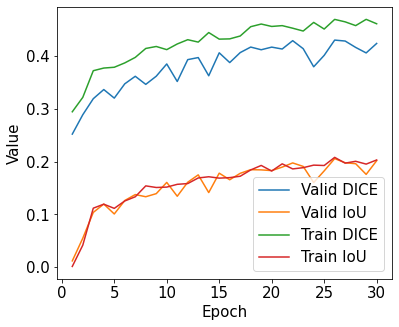

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
x2 = range(1, len(valid_dice)+1)
y2 = valid_dice
plt.plot(x2, y2, label = "Valid DICE")


x3 = range(1, len(valid_iou)+1)
y3 = valid_iou
plt.plot(x3, y3, label = "Valid IoU")


x5 = range(1, len(train_dice)+1)
y5 = train_dice
plt.plot(x5, y5, label = "Train DICE")

x6 = range(1, len(train_iou)+1)
y6 = train_iou
plt.plot(x6, y6, label = "Train IoU")

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc=4)
plt.show()

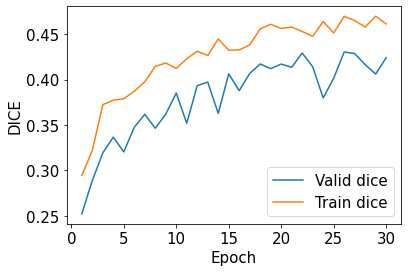

In [46]:

x1 = range(1,len(valid_dice)+1)
y1 = valid_dice

plt.plot(x1, y1, label = "Valid dice")

x4 = range(1, len(train_dice)+1)
y4 = train_dice
plt.plot(x4, y4, label = "Train dice")

plt.xlabel('Epoch')
plt.ylabel('DICE')
plt.legend()
plt.show()